In [92]:
# Copyright (c) 2023, Neos Wave
# All rights reserved.
# Written by David Jacobs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
import textstat as txtst
print("Setup Complete")

Setup Complete


# Preprocessing

### Loading file & Setting up first df (Needs the filepath of the scrape changed between quotations)

For the filepath change \ --> / and remember to add ".csv" at the end.

Headers needed for Scrape to work:

['Breadcrumbs', 'Article Title', 'Article Text']

In [93]:
filepath = input('Filepath of the scrape\n')

df = pd.read_csv(filepath)

Filepath of the scrape
C:/Users/Work Section/OneDrive/Documents/New PyCharm Dir/pythonProject/Projects/Tests/The Black Tux KB Scrape.csv


### Adding Who's KB is this? (Needs input at prompt)

In [94]:
print('Who\'s KB is this?')
client = input()

Who's KB is this?
The Black Tux


### Splitting the Breadcrumbs into KB Name, Category, Subcategory

In [95]:
def split_breadcrumbs(row):
    bread_list = row['Breadcrumbs'].split('|')
    row['KB Name'] = bread_list[0]
    if len(bread_list) >= 3:
        row['Category'] = bread_list[1]
        row['Subcategory'] = bread_list[2]
    elif len(bread_list) == 2:
        row['Category'] = bread_list[1]
        row['Subcategory'] = 'None'
    elif len(bread_list) == 1:
        row['Category'] = 'None'
        row['Subcategory'] = 'None'
    return row

df = df.apply(split_breadcrumbs, axis=1)

### Cleaning up the Subcategory

In [96]:
def clean_subcat(row):
    if row['Subcategory'] == row['Article Title']:
        row['Subcategory'] = 'None'
        return row
    else:
        return row

df = df.apply(clean_subcat, axis=1)

### Adding a Category Index

In [97]:
categories = list(df['Subcategory'].unique())
# For the Black Tux the brand used subcategories as their categories. 

df['Category Index'] = df['Subcategory'].map(lambda cat: categories.index(cat))

In [98]:
df = df[['KB Name', 'Category Index', 'Category', 'Subcategory', 'Article Title', 'Article Text']]

### Filling in NA

In [99]:
df = df.fillna(' ')

### Combining Article Title & Text to get full Article Copy

In [100]:
def combine_text(row):
    row['Article Copy'] = str(row['Article Title']) + ' ' + str(row['Article Text'])
    return row

df2 = df.apply(combine_text, axis='columns')

### Creating the Average Time to Read (ATR in seconds)

In [101]:
df2['ATR'] = df2['Article Copy'].map(lambda text: txtst.lexicon_count(text, removepunct=True) / 200)

In [102]:
df2.groupby('Subcategory')['ATR'].agg([len, min, max, np.mean]).sort_values(by='mean', ascending=False)

,len,min,max,mean
Subcategory,,,,
Wedding Parties,16,0.200,2.460,0.765938
Order Changes,6,0.285,1.325,0.681667
Returns & Cancellations,10,0.180,1.220,0.653500
In-Person Fitting,16,0.170,1.840,0.636563
Shipping,10,0.215,1.005,0.565500
How It Works,27,0.110,2.125,0.554630
David's Bridal,7,0.150,1.280,0.526429
Payments & Discounts,14,0.075,0.865,0.364286
Marke NYC,12,0.125,0.560,0.360417


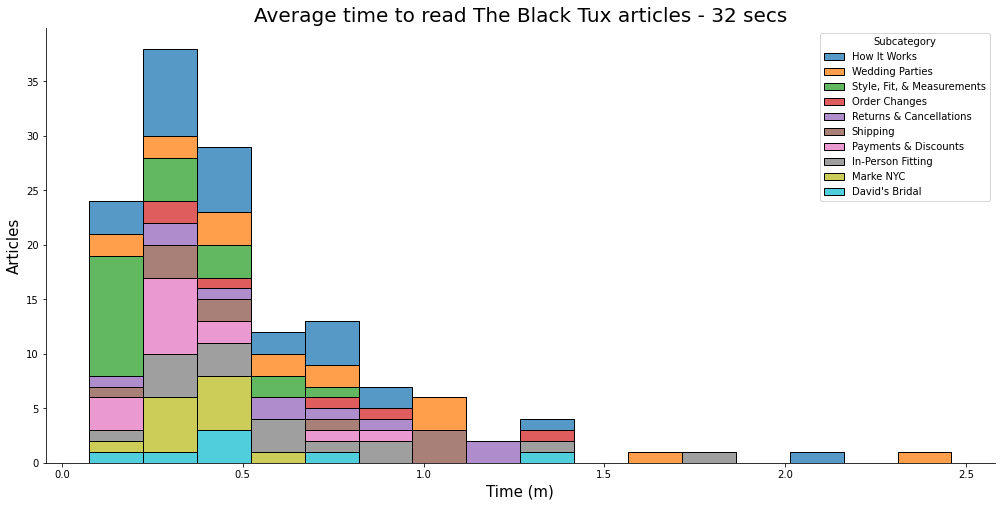

In [114]:
atr_mins = str(int(np.mean(df2['ATR'])))

atr_secs = str(math.floor(round((np.mean(df2['ATR']) - math.floor(np.mean(df2['ATR']))) * 60, 0)))

plt.figure(figsize=(17,8))

ax = sns.histplot(data=df2, x='ATR', hue='Subcategory', multiple='stack', palette='tab10')

if atr_mins == str(1):
    ax.set_title(f"Average time to read {client} articles - {atr_mins} min {atr_secs} secs", fontsize=20)
elif atr_mins == str(0):
    ax.set_title(f"Average time to read {client} articles - {atr_secs} secs", fontsize=20)
elif atr_mins != str(1):
    ax.set_title(f"Average time to read {client} articles - {atr_mins} mins {atr_secs} secs", fontsize=20)

plt.xlabel("Time (m)", fontsize=15)

plt.ylabel("Articles", fontsize=15)

sns.despine()

plt.show()

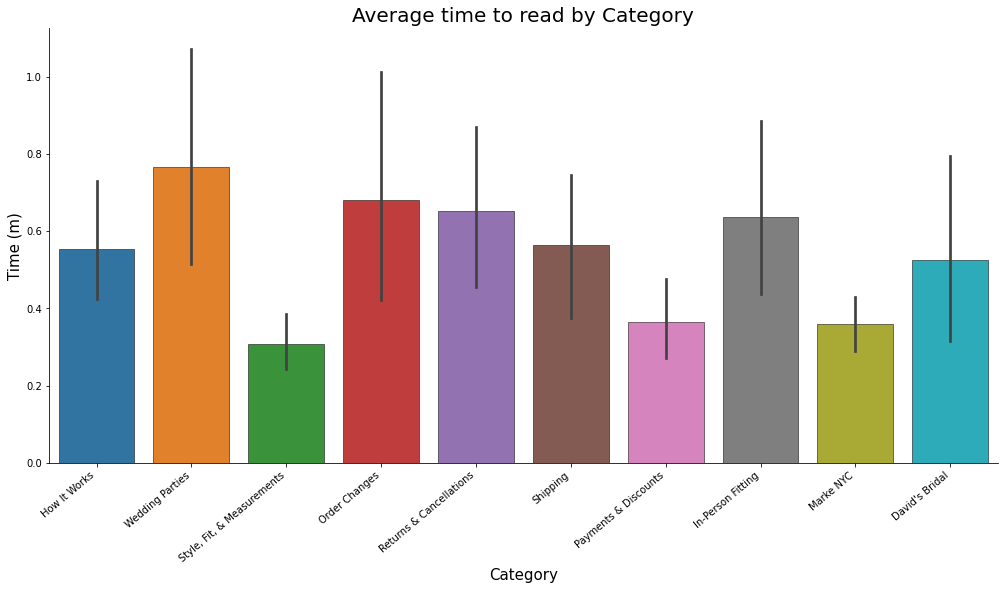

In [115]:
plt.figure(figsize=(17,8))

ax = sns.barplot(data=df2, x='Subcategory', y='ATR', palette='tab10', edgecolor='black', linewidth=0.5)

ax.set_title('Average time to read by Category', fontsize=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.xlabel('Category', fontsize=15)

plt.ylabel('Time (m)', fontsize=15)

sns.despine()

plt.show()

### Adding Words per Article

In [105]:
df2['Word Count'] = df2['Article Copy'].map(lambda text: txtst.lexicon_count(text, removepunct=True))

### Reading Ease - Flesch Reading Ease (% out of 100)

In [106]:
df2['Reading Ease'] = df2['Article Copy'].map(lambda text: txtst.flesch_reading_ease(text))

In [107]:
df2.groupby('Subcategory')['Reading Ease'].agg([len, min, max, np.mean]).sort_values(by='mean', ascending=False)

,len,min,max,mean
Subcategory,,,,
Order Changes,6,73.88,88.74,80.813333
"Style, Fit, & Measurements",21,60.95,95.47,80.306190
Shipping,10,56.76,99.26,77.786000
Returns & Cancellations,10,65.52,90.29,77.111000
How It Works,27,55.24,90.09,77.092222
Marke NYC,12,58.32,85.49,72.775833
Wedding Parties,16,46.61,82.65,70.125625
Payments & Discounts,14,41.06,82.24,69.213571
In-Person Fitting,16,51.78,85.39,66.387500


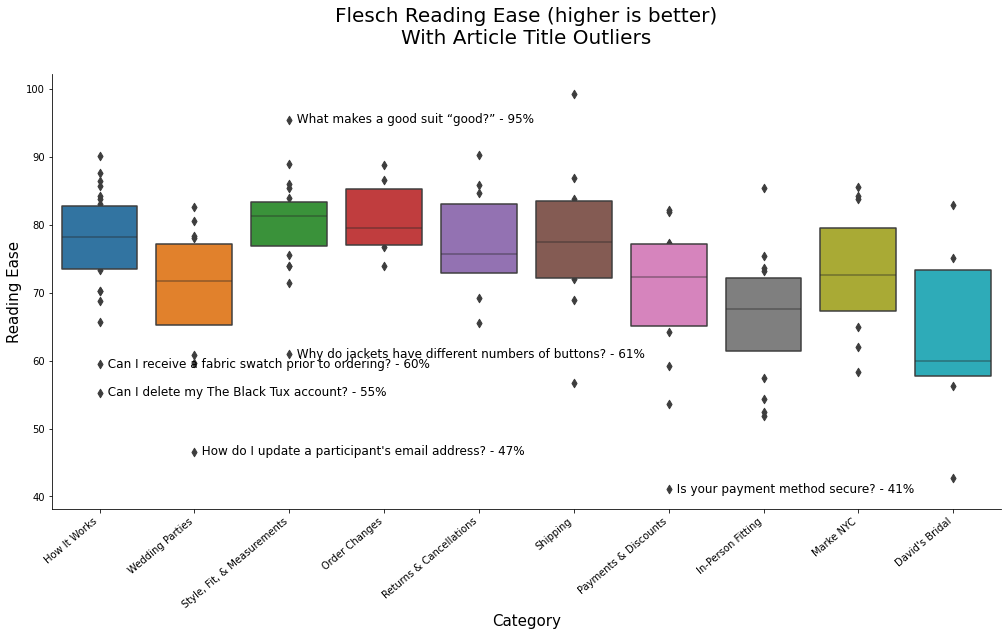

In [118]:
plt.figure(figsize=(17,8))

ax = sns.boxenplot(data=df2, x='Subcategory', y='Reading Ease', palette='tab10')

ax.set_title('Flesch Reading Ease (higher is better)\nWith Article Title Outliers', fontsize=20, pad=30)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.xlabel("Category", fontsize=15)

plt.ylabel("Reading Ease", fontsize=15)

cat_q1 = df2.groupby('Category Index').quantile(0.25)['Reading Ease'].to_numpy()
cat_q3 = df2.groupby('Category Index').quantile(0.75)['Reading Ease'].to_numpy()
outlier_top_lim = cat_q3 + 1.5 * (cat_q3 - cat_q1)
outlier_bottom_lim = cat_q1 - 1.5 * (cat_q3 - cat_q1)

for row in df2.itertuples():
    cat_index = row[2]
    title = row[5]
    val = row[10]
    if val > outlier_top_lim[cat_index] or val < outlier_bottom_lim[cat_index]:
        plt.text(cat_index, val, f'  {title} - {round(val)}%', ha = 'left', va = 'center', 
                 size = 'large', weight = 'roman', rotation=0)
        
sns.despine()

plt.show()

### Difficult Words % - Difficult Words (words with 3 or more syllables) / Total # of Words

In [110]:
def difficult_words(row):
    row['Difficult Words (%)'] = round(100 * txtst.difficult_words(row['Article Copy']) / row['Word Count'], 2)
    return row

df2 = df2.apply(difficult_words, axis='columns')

In [111]:
df2.groupby('Subcategory')['Difficult Words (%)'].agg([len, min, max, np.mean]).sort_values(by='mean', ascending=False)

,len,min,max,mean
Subcategory,,,,
Payments & Discounts,14,13.64,35.85,20.066429
In-Person Fitting,16,8.57,22.89,17.116250
David's Bridal,7,10.00,23.08,16.008571
Marke NYC,12,10.53,22.22,15.380833
"Style, Fit, & Measurements",21,5.88,22.54,14.511905
Wedding Parties,16,10.00,20.33,14.175000
Shipping,10,4.65,29.31,13.827000
How It Works,27,5.00,27.12,13.587778
Returns & Cancellations,10,8.79,17.70,13.585000


### Syllable Count

In [18]:
df2['Syllable Count'] = df2['Article Copy'].map(lambda text: txtst.syllable_count(text))

### Sentence Count

In [19]:
df2['Sentence Count'] = df2['Article Copy'].map(lambda text: txtst.sentence_count(text))

### Adding Industry & Help Center Tech (Needs input of Industry from Hubspot)

Look up the client in Hubspot and look for industry field

In [19]:
print('Which industry is the KB from?')
industry = input()
df2['Industry'] = industry

Which industry is the KB from?
Ecommerce


### Help Center Tech (Needs input from which type of Help Center used)

Look at html in the help center to find out which one

In [20]:
print('Which Help Center Tech are they using?\n-Intercom\n-Zendesk\n-Hubspot\n-Salesforce\n-Kustomer\n-Zoho\n-Freshdesk\n-Gorgias\n-No CS Platform')
tech = input()
df2['Help Center Tech'] = tech

Which Help Center Tech are they using?
-Intercom
-Zendesk
-Hubspot
-Salesforce
-Kustomer
-Zoho
-Freshdesk
-Gorgias
-No CS Platform
Zendesk


# Exporting to Local, Google Drive & Slides

### Local save

In [21]:
df2.to_csv(f'{client} Data Saved Down.csv', index=False, encoding = 'utf-8-sig')

In [22]:
import gspread

service_file = [INSERT JSON FILEPATH]

### Adding to Slides Template Sheet

In [23]:
gc = gspread.service_account(filename=service_file)

sh = gc.open("Template Feed to KB Slides")

In [24]:
worksheet = sh.worksheet("Data")

worksheet.clear()

worksheet.update([df2.columns.values.tolist()] + df2.values.tolist())

{'spreadsheetId': '1rjpp9TjdpRUSbhWayHLCLiZO2kSk4SBuBN5Yj0TJLQw',
 'updatedRange': 'Data!A1:O25',
 'updatedRows': 25,
 'updatedColumns': 15,
 'updatedCells': 375}

### Adding df2 to Google Drive

In [25]:
sh_create = gc.create(f'{client} Data Saved Down', folder_id=[INSERT FOLDER ID])

worksheet_1 = sh_create.sheet1

worksheet_1.update([df2.columns.values.tolist()] + df2.values.tolist())

{'spreadsheetId': '1YLNL7RdOrt5An9cEo5wVrnk7x_3rSgPLmvjp9BIrZzU',
 'updatedRange': 'Sheet1!A1:O25',
 'updatedRows': 25,
 'updatedColumns': 15,
 'updatedCells': 375}